# Problème n°2: PointNet

Certains jeux de données impliquent des nuages de points dans un espace 3D. Penser par exemple à un ensemble de mesures lidar : chaque tir permet de renseigner les coordonnées d'un des points de l'objet ciblé.
Une tâche intéressante consiste à classer chacun des points du nuage en fonction de l'objet auquel il appartient. Cette tâche est considérée comme une variante de la segmentation sémantique d'images.

Ce problème introduit à une méthode directe de segmentation d'un nuage par deep learning. Elle est basée sur une architecture particulière appelée PointNet. \
Dans la première partie, on présente un jeu de données (synthétisé à la volée) impliquant des nuages de points.
Dans la seconde partie, on explore la structure et les propriétés de PointNet. Dans la troisième, on l'entraîne et dans la dernière partie, on charge les poids d'une version améliorée de PointNet (PointNet++) pour comparaison.

La cellule suivante permet les imports nécessaires:

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import matplotlib.pyplot as plt
import os
!pip install --upgrade sympy
! pip install einops
! git clone https://github.com/AnaisCharpentier/exam_2025.git
! cp exam_2025/utils/utils_probleme2.py .
from utils_probleme2 import gen_pointcloud, plot_triplets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 76.1 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.1
    Uninstalling sympy-1.13.1:
      Successfully uninstalled sympy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu121 requires sympy==1.13.1; python_version >= "3.9", but you have sympy 1.13.3 which is incompatible.


fatal: destination path 'exam_2025' already exists and is not an empty directory.


## Partie I : un exemple de PointCLoud data

Pour construire le jeu de données, on simule un terrain couvert de deux types de bâtiments : des immeubles de forme rectangulaire aux toits plats et des igloos (dômes). Pour créer les nuages, on échantillonne les surfaces vues du ciel (les murs des bâtiments rectangulaires ne sont pas échantillonnées), en favorisant les zones d'altitude non nulles.
Le but est de distinguer les igloos du reste (sol et toits des bâtiments). Il s'agit donc d'une segmentation binaire.

0


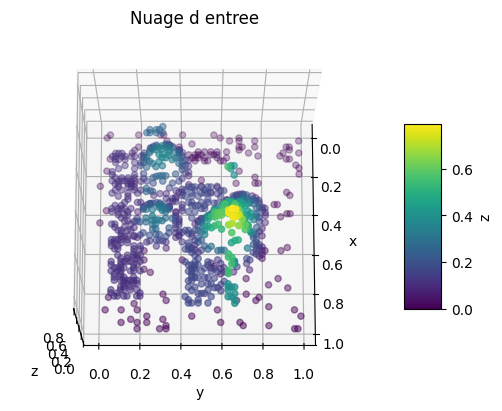

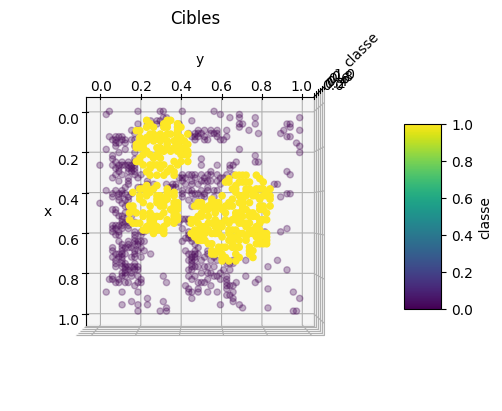

TypeError: iteration over a 0-d tensor

In [2]:
batch_size = 6
input_points, target_list, target_points  = gen_pointcloud(batch_size)


for i in range(batch_size):
  print(i)
  # Représentation 3D des nuages de points et
  # les paramètres elev et azim permettent de changer l'angle de vue
  plot_triplets(input_points[i].transpose(0,1).cpu(),
                elev=75, azim=0)

  # Cibles : les points appartenant aux toitures d'igloos sont
  # dans la classe 1, les autres, dans la classe 0.
  plot_triplets(target_points[i].transpose(0,1).cpu(),
                title='Cibles',
                cbar_label='classe')

  # Note: target_points contient non seulement les classes
  # mais aussi les coordonnées x et y des points, pour
  # faciliter leur visualisation
  plot_triplets(target_list[i].cpu(),
                title='Cibles',
                cbar_label='classe')



In [3]:
 print(input_points.shape)

torch.Size([6, 3, 800])


**Q1** A quoi correspondent les différentes dimensions de *input_points* ?  


la dimension 1 repésente le numéro du batch elle est donc de taille 6.    

la dimension 2 représente les coordonnées du point dans l'espace.  

la dimesion 3 représente le numéro du point dans le nuage, elle est de taille 8OO come la dim d'un nuage.


**Q2** Les points d'un nuage sont-ils rangés dans un ordre particulier ?  

Non il ne semble pas ranger dans un ordre particulier puisqu'ils sont echantillonnés aléatoirement à partir des surfaces des batiments.

**Q3** (question ouverte). Si vous deviez traiter le problème avec un FCN ou un ViT (Visual Transformer), que feriez-vous ?  

Ces modèles sont generalement concu pour des images 2D , il faudrait donc projeter les nuages de points sur une image 2D puis appliquer un des deux modèles

## Partie II : le modèle PointNet

Dans cette partie, on s'intéresse à la propriété principale d'un réseau PointNet : l'utilisation d'opérations invariantes par rapport à l'ordre dans lequel les points sont présentés au réseau.

In [5]:
from utils_probleme2 import PointNetSegHead
pointnet = PointNetSegHead(num_points=800, num_global_feats=1024, m=2).cuda()

input_points, target_list, _ = gen_pointcloud(batch_size)
input_points = input_points.cuda()
output, _, _ = pointnet(input_points)



print(output.shape)

torch.Size([6, 800, 2])


**Q1** La sortie du modèle PointNet correspond au premier tenseur du *tuple* fourni la fonction *forward* de *pointnet*. A quoi correspondent les différentes dimensions de *output* ? Quel est l'effet d'une permutation des points contenus dans *inputs_points* sur la sortie ? Répondre :

- en vous référant à l'article [l'article](https://arxiv.org/abs/1612.00593) qui introduit ce réseau (citer dans le texte).
- à partir de tests à effectuer dans la cellule de code suivante (utiliser torch.randperm pour générer des permutations sur les entrées)

Q1. Première dimension: Représente le numéro du lot (batch). Elle a la même taille que la première dimension de input_points, soit batch_size = 6  

Deuxième dimension: Représente le nombre de points dans le nuage de points, qui est num_points, de dim 800  

Troisième dimension: Représente le nombre de classes de segmentation. Il s'agit d'une segmentation binaire (igloos vs. autres), donc cette dimension est de taille 2 (une probabilité pour chaque classe).  


Effet d'une permutation des points d'entrée:  
PointNet est conçu pour être invariant à l'ordre des points d'entrée. Cela signifie que la permutation des points dans input_points ne devrait pas affecter significativement la sortie output.


In [9]:
import torch

# Générer une permutation aléatoire des indices des points
idx = torch.randperm(input_points.shape[1])

# Permuter les points dans input_points
permuted_input_points = input_points[:, idx, :]

# Calculer la sortie du modèle avec les points permutés
permuted_output, _, _ = pointnet(permuted_input_points)

# Comparer output et permuted_output
# (par exemple, en calculant la différence absolue moyenne)
diff = torch.mean(torch.abs(output - permuted_output))

print(f"Différence moyenne entre les sorties: {diff}")

Différence moyenne entre les sorties: 0.9013869166374207


**Q2** L'architecture de *pointnet* est décrite dans la Figure 2 de l'article (voir ci-dessous) évoqué à la question précédente. En dehors des opérations notées "input transform" et "feature transform", dont la compréhension est plus délicate, quelles sont les différentes opérations conduisant à une segmentation ? Que signifie le terme "shared" et expliquer en quoi ces opérations sont invariantes par rapport à l'ordre de présentation des points.

 les principales opérations conduisant à une segmentation dans PointNet sont:

  mlp (64, 64, 128, 1024): de Multi-Layer Perceptrons (réseaux de neurones multicouches) appliqués indépendamment à chaque point du nuage de points. Ils extraient des caractéristiques locales pour chaque point.

  max pool: opération qui effectue un max pooling sur toutes les caractéristiques des points, produisant un vecteur de caractéristiques globales pour le nuage de points entier. C'est l'étape clé qui rend PointNet invariant à l'ordre des points, car le résultat du max pooling est indépendant de l'ordre des éléments en entrée.

  mlp (512, 256, 128, m): Un autre MLP est appliqué au vecteur de caractéristiques globales pour produire des scores de segmentation pour chaque point.  
  
  
  
  pour le terme shared:  
  Le terme "shared" signifie que l'opération(nottament pour le dernier MLP) est appliqué à tous les points du nuage de points et ceux avec les mêmes poids et biais.  


pour l'invariance à l'ordre:
Les opérations dans PointNet sont invariantes à l'ordre de présentation des points grâce à l'utilisation de fonctions symétriques. PAr exemple le max pooling sélectionne la valeur maximale parmi un ensemble d'éléments donc il ne tient pas compte de leur ordre.



<img src= https://miro.medium.com/v2/resize:fit:1100/format:webp/1*lFnrIqmV_47iRvQcY3dB7Q.png >

## Partie III

Dans cette partie, on se propose d'entraîner un PointNet. Pour ce faire, on utilisera une fonction de coût spécifique (voir cellule ci-dessous).

**Consignes :**

1) Entraîner un PointNet sur quelques centaines d'époques.

2) Afficher à chaque époque la justesse des prédictions

3) Charger les poids d'un réseau entraîné sur 500 époques, stockés dans le fichier **pointnet_500_ep.pth** du répertoire https://huggingface.co/nanopiero/pointnet_igloos.

Visualiser les sorties de ce modèle-là en complétant le la dernière cellule de code du calepin.


In [15]:
import torch
import sympy
import numpy as np
from utils_probleme2 import PointNetSegHead, gen_pointcloud

# Initialisation du modèle, de l'optimiseur et de la fonction de coût
pointnet = PointNetSegHead(num_points=800, num_global_feats=1024, m=2).cuda()
optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.0001, betas=(0.9, 0.999))
loss_fn = torch.nn.CrossEntropyLoss().cuda()  # Utilisation de CrossEntropyLoss

# Paramètres d'entraînement
batch_size = 64
n_epochs = 200  # Vous pouvez ajuster le nombre d'époques
n_batch_per_epoch = 10

# Boucle d'entraînement
for epoch in range(1, n_epochs + 1):
    print(f"Epoch: {epoch}/{n_epochs}")
    for batch in range(1, n_batch_per_epoch + 1):
        # Générer des données d'entraînement
        input_points, target_list, _ = gen_pointcloud(batch_size)
        input_points = input_points.cuda()
        target_list = target_list.cuda()

        # Réinitialiser les gradients
        optimizer.zero_grad()

        # Calculer les sorties du modèle
        outputs, _, _ = pointnet(input_points)

        # Calculer la perte avec CrossEntropyLoss
        loss = loss_fn(outputs.transpose(1, 2), target_list)

        # Rétropropagation et mise à jour des poids
        loss.backward()
        optimizer.step()

    # Afficher la justesse des prédictions à chaque époque
    with torch.no_grad():
        input_points, target_list, _ = gen_pointcloud(batch_size)
        input_points = input_points.cuda()
        input_points, target_list, _ = gen_pointcloud(batch_size)
        input_points = input_points.cuda()
        target_list = target_list.cuda()
        outputs, _, _ = pointnet(input_points)
        predictions = outputs.transpose(1, 2).max(1)[1]
        accuracy = (predictions == target_list).float().mean()
        print(f"Accuracy: {accuracy.item()}")


AttributeError: module 'sympy' has no attribute 'printing'

In [10]:
optimizer = torch.optim.Adam(pointnet.parameters(),
                             lr=0.0001, betas=(0.9, 0.999))

# manually set alpha weights
alpha = np.array([0.2, 0.8])
gamma = 1
loss_fn = PointNetSegLoss(alpha=alpha, gamma=gamma, dice=True).cuda()

# exemple d'utilisation de PointNetSegLoss:
# La transposition permet de repasser la dimension relative
# aux probabilités en dernier, comme avec torch.nn.CrossEntropyLoss
proba_pred_list = outputs.transpose(1,2)
loss_fn(proba_pred_list, target_list)

AttributeError: module 'sympy' has no attribute 'printing'

In [ ]:
batch_size = 64
n_epochs = 200
n_batch_per_epoch = 10


for epoch in range(1, n_epochs):
  print('epoch : ', epoch)
  for batch in range(1,n_batch_per_epoch):
    ...

In [ ]:
input_points, target_list , target_points = gen_pointcloud(6)

# Il faut construire les prédictions.
proba_pred_list, _, _ = pointnet2.cuda()(input_points.to(device))
pred_list = proba_pred_list.transpose(1,2).max(1)[1].cpu()

# Accuracy:
...
# Tracé

for i in range(6):
  print(i)
  plot_triplets(input_points[i].transpose(0,1), elev=75, azim=0)
  plot_triplets(target_points[i].transpose(0,1),
                title='Cibles',
                cbar_label='classe')
  plot_triplets(...,
                title='Predictions',
                cbar_label='classe')
